<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !pip install ./deepul
# !pip install scikit-learn

In [2]:
import os
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from deepul.hw4_helper import *
from deepul import pytorch_util as ptu

In [3]:
ptu.set_gpu_mode(True)

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

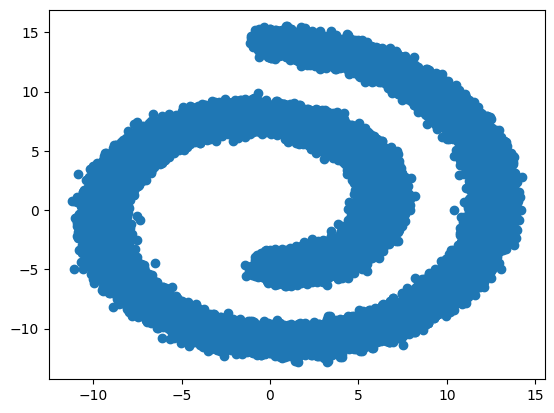

In [4]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

## Data processing

In [5]:
def norm_mean_std(train_data, test_data):
    mean = train_data.mean(axis=0)
    std = train_data.std(axis=0)
    train_data = (train_data - mean) / std
    test_data = (test_data - mean) / std

    return train_data, test_data, mean, std


def unnorm_mean_std(data, mean, std):
    return data * std + mean


def norm_img(data):
    return data * 2 - 1


def unnorm_img(data):
    return (data + 1) / 2

## Models

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            # +1 for time concatenation
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x_t, t):
        # x_t: (batch_size, input_dim)
        # t: (batch_size,)
        t = t.view(-1, 1)  # Reshape t to (batch_size, 1)
        x = torch.cat((x_t, t), dim=-1)  # Concatenate x and t
        return self.net(x)

## LR Schedule

In [7]:
def warmup_cosine_decay_scheduler(optimizer, warmup_steps, total_steps):
    """
    Creates a scheduler with warmup followed by cosine decay.

    Args:
        optimizer: Optimizer linked to the model parameters.
        warmup_steps: Number of steps for the warmup phase.
        total_steps: Total number of steps in the training.
    """

    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        # Cosine decay
        progress = float(current_step - warmup_steps) / float(
            max(1, total_steps - warmup_steps)
        )
        return 0.5 * (1.0 + np.cos(np.pi * progress))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

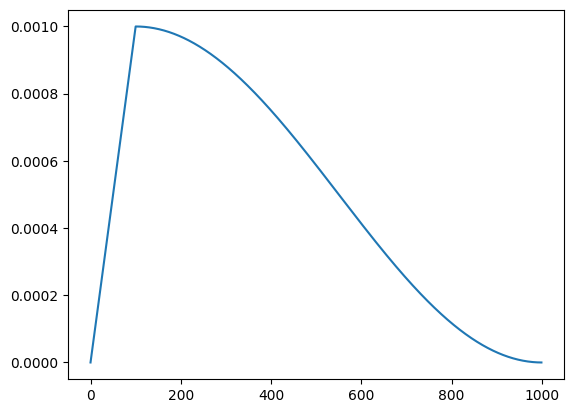

In [8]:
dummy_opt = optim.Adam([nn.Parameter(torch.zeros(1))])
total_steps = 1_000
lr_scheduler = warmup_cosine_decay_scheduler(dummy_opt, warmup_steps=100, total_steps=total_steps)
lrs = []
for _ in range(total_steps):
    lrs.append(lr_scheduler.get_last_lr())
    lr_scheduler.step()
plt.plot(lrs)

## Diffusion model

In [21]:
class DiffusionModel(object):
    def __init__(
        self,
        train_data,
        test_data,
        model=None,
        batch_size=1024,
        n_epochs=100,
        n_warmup_steps=100,
        has_labels=False,
    ):
        self.n_epochs = n_epochs
        self.has_labels = has_labels

        # Data loaders
        if isinstance(train_data, torch.utils.data.DataLoader):
            assert isinstance(test_data, torch.utils.data.DataLoader)
            self.train_loader = train_data
            self.test_loader = test_data
            train_data_shape = None
        else:
            train_data_shape = train_data.shape
            self.train_loader, self.test_loader = self.create_loaders(
                train_data, test_data, batch_size
            )

        if model is None:
            assert train_data_shape is not None and len(train_data_shape) == 2
            input_dim = train_data_shape[1]
            self.model = MLP(input_dim, input_dim)
        else:
            self.model = model
        self.model = self.model.to(ptu.device)

        if has_labels:
            self.model_fn = lambda x, labels, t: self.model(x, labels, t)
        else:
            self.model_fn = lambda x, labels, t: self.model(x, t)

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

        # LR scheduler
        n_iters_per_epoch = len(self.train_loader)
        n_iters = n_epochs * n_iters_per_epoch
        self.scheduler = warmup_cosine_decay_scheduler(
            self.optimizer, n_warmup_steps, n_iters
        )

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

    def create_loaders(self, train_data, test_data, batch_size):
        train_data = torch.tensor(train_data, dtype=torch.float32)
        test_data = torch.tensor(test_data, dtype=torch.float32)

        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=batch_size, shuffle=False
        )
        return train_loader, test_loader

    def get_alpha(self, t):
        return torch.cos(np.pi / 2 * t).to(ptu.device)

    def get_sigma(self, t):
        return torch.sin(np.pi / 2 * t).to(ptu.device)

    def compute_loss(self, x, labels=None):
        batch_size = x.shape[0]

        # Step 1: Sample diffusion timestep uniformly in [0, 1]
        t = torch.rand(batch_size, device=ptu.device)  # [batch_size]

        # Step 2: Compute noise-strength
        alpha_t = self.get_alpha(t)
        sigma_t = self.get_sigma(t)

        # Step 3: Apply forward process
        epsilon = torch.randn_like(x, device=ptu.device)
        exp_shape = [batch_size] + [1] * (len(x.shape) - 1)
        # print(alpha_t.shape, x.shape, sigma_t.shape, epsilon.shape)
        # print("exp_shape", exp_shape)
        alpha_t = alpha_t.view(exp_shape)
        sigma_t = sigma_t.view(exp_shape)
        x_t = alpha_t * x + sigma_t * epsilon  # x.shape

        # Step 4: Estimate epsilon
        eps_hat = self.model_fn(x_t, labels, t)

        # Step 5: Optimize the loss
        # loss = (epsilon - eps_hat).pow(2).sum(axis=1).mean()
        loss = (epsilon - eps_hat).pow(2).mean()
        return loss

    def eval(self, test_loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x in test_loader:
                if self.has_labels:
                    x, labels = x
                    labels = labels.to(ptu.device)
                else:
                    labels = None
                x = x.to(ptu.device)
                loss = self.compute_loss(x, labels)
                total_loss += loss.item() * x.shape[0]

        return total_loss / len(test_loader.dataset)

    def train(self, log_freq=100, save_freq: int = 10, save_dir=None):
        if save_dir is not None:
            # Get the current timestamp and save it as a new directory.
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            save_dir = os.path.join(save_dir, timestamp)
            os.makedirs(save_dir)

        train_losses = []
        test_losses = [self.eval(self.test_loader)]

        iter = 0
        for epoch in range(self.n_epochs):
            epoch_train_losses = []
            self.model.train()

            for x in self.train_loader:
                if self.has_labels:
                    x, labels = x
                    labels = labels.to(ptu.device)
                else:
                    labels = None
                x = x.to(ptu.device)
                self.optimizer.zero_grad()
                loss = self.compute_loss(x, labels)
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                epoch_train_losses.append(loss.item())

                if log_freq is not None and iter % log_freq == 0:
                    print(f"Epoch {epoch+1}, iter {iter}, Loss: {loss.item()}")

                iter += 1

            train_losses.extend(epoch_train_losses)
            test_losses.append(self.eval(self.test_loader))

            if save_dir is not None and epoch % save_freq == 0:
                self.save(os.path.join(save_dir, f"diffusion_model_epoch_{epoch}.pt"))

        if save_dir is not None:
            self.save(os.path.join(save_dir, "diffusion_model_final.pt"))
            np.save(os.path.join(save_dir, "train_losses.npy"), train_losses)
            np.save(os.path.join(save_dir, "test_losses.npy"), test_losses)

        return train_losses, test_losses


def ddpm_update(x, eps_hat, alpha_t, alpha_tm1, sigma_t, sigma_tm1, clip=None):
    eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t.pow(2) / alpha_tm1.pow(2))
    x_tm1_mean = (x - sigma_t * eps_hat) / alpha_t
    if clip is not None:
        min, max = clip
        x_tm1_mean = torch.clamp(x_tm1_mean, min, max)
    update_term = alpha_tm1 * x_tm1_mean
    noise_term = (
        torch.sqrt(torch.clamp(sigma_tm1.pow(2) - eta_t.pow(2), min=0)) * eps_hat
    )
    random_noise = eta_t * torch.randn_like(x, device=ptu.device)
    x_tm1 = update_term + noise_term + random_noise
    return x_tm1


def sample(model, num_samples, return_steps, data_shape, clip=None):
    model.model.eval()
    if not isinstance(data_shape, (list, tuple)):
        data_shape = (data_shape,)
    x_shape = (num_samples,) + tuple(data_shape)
    exp_shape = [num_samples] + [1] * len(data_shape)
    samples = []

    for num_steps in return_steps:
        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)

        with torch.no_grad():
            x = torch.randn(x_shape, device=ptu.device)
            for i in range(num_steps):
                t = ptu.tensor([ts[i]], dtype=torch.float32)
                tm1 = ptu.tensor([ts[i + 1]], dtype=torch.float32)

                alpha_t = model.get_alpha(t).expand(exp_shape)
                alpha_tm1 = model.get_alpha(tm1).expand(exp_shape)
                sigma_t = model.get_sigma(t).expand(exp_shape)
                sigma_tm1 = model.get_sigma(tm1).expand(exp_shape)

                eps_hat = model.model(x, t.expand(num_samples))
                x = ddpm_update(
                    x, eps_hat, alpha_t, alpha_tm1, sigma_t, sigma_tm1, clip=clip
                )

            samples.append(x.cpu().detach().numpy())

    samples = np.array(samples)
    return samples


# My original sample function, which returns some samples that haven't completed
# the denoising process.
# def sample(model, num_samples, num_steps, return_steps, data_shape, clip=None):
#     model.model.eval()
#     # Original: ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
#     ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
#     if not isinstance(data_shape, (list, tuple)):
#         data_shape = (data_shape,)
#     x_shape = (num_samples,) + tuple(data_shape)
#     exp_shape = [num_samples] + [1] * len(data_shape)

#     samples = []
#     with torch.no_grad():
#         x = torch.randn(x_shape, device=ptu.device)
#         for i in range(num_steps):
#             t = ptu.tensor([ts[i]], dtype=torch.float32)
#             tm1 = ptu.tensor([ts[i + 1]], dtype=torch.float32)

#             alpha_t = model.get_alpha(t).expand(exp_shape)
#             alpha_tm1 = model.get_alpha(tm1).expand(exp_shape)
#             sigma_t = model.get_sigma(t).expand(exp_shape)
#             sigma_tm1 = model.get_sigma(tm1).expand(exp_shape)

#             eps_hat = model.model(x, t.expand(num_samples))
#             x = ddpm_update(
#                 x, eps_hat, alpha_t, alpha_tm1, sigma_t, sigma_tm1, clip=clip
#             )

#             if i + 1 in return_steps:
#                 samples.append(x.cpu().detach().numpy())

#     samples = np.array(samples)
#     return samples


## From Jivat:
# def ddpm_update(x, eps_hat, t, tm1):
#     alpha_t = torch.cos(np.pi * t / 2)
#     sigma_t = torch.sin(np.pi * t / 2)
#     alpha_tm1 = torch.cos(np.pi * tm1 / 2)
#     sigma_tm1 = torch.sin(np.pi * tm1 / 2)

#     eta_t = (sigma_tm1 / sigma_t) * torch.sqrt(1 - (alpha_t**2 / alpha_tm1**2))

#     x_tm1_mean = (x - sigma_t * eps_hat) / alpha_t
#     update_term = alpha_tm1 * x_tm1_mean
#     noise_term = (
#         torch.sqrt(torch.clamp(sigma_tm1.pow(2) - eta_t.pow(2), min=0)) * eps_hat
#     )

#     random_noise = eta_t * torch.randn_like(x, device=ptu.device)

#     x_tm1 = update_term + noise_term + random_noise
#     return x_tm1


# def sample(model, n, time_steps):
#     sample_array = []
#     with torch.no_grad():
#         for num_steps in time_steps:
#             ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
#             x = torch.randn(n, 2).to(ptu.device)
#             for i in range(num_steps):
#                 t = (torch.ones(n, 1) * ts[i]).to(ptu.device)
#                 tm1 = (torch.ones(n, 1) * ts[i + 1]).to(ptu.device)
#                 eps_hat = model.model(x, t)
#                 x = ddpm_update(x, eps_hat, t, tm1)
#             sample_array.append(x.cpu().numpy())
#         samples = np.stack(sample_array, axis=0)
#         return samples

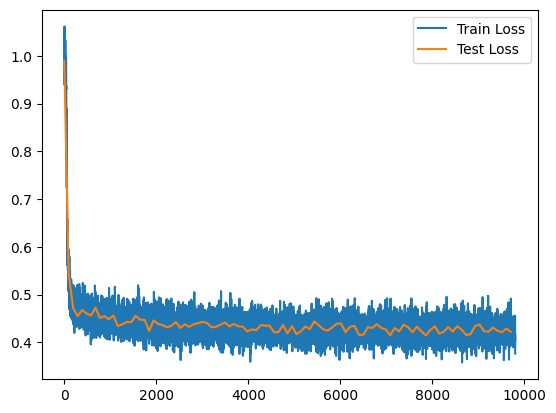

In [10]:
# train_data = q1_data(n=100000)
# test_data = q1_data(n=10000)

# train_data, test_data, mean, std = norm_mean_std(train_data, test_data)

# diffusion_model = DiffusionModel(
#     train_data, test_data, batch_size=1024, n_epochs=100, n_warmup_steps=100
# )
# # Load
# load_dir = (
#     "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q1/2024-03-18_10-27-15"
# )
# diffusion_model.load(os.path.join(load_dir, "diffusion_model_final.pt"))
# train_losses = np.load(os.path.join(load_dir, "train_losses.npy"))
# test_losses = np.load(os.path.join(load_dir, "test_losses.npy"))
# # Save
# # save_dir = "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q1"
# # train_losses, test_losses = diffusion_model.train(save_dir=save_dir)

# # Plot train/test losses
# plt.plot(train_losses, label="Train Loss")
# plt.plot(
#     np.linspace(0, len(train_losses), len(test_losses), endpoint=False),
#     test_losses,
#     label="Test Loss",
# )
# plt.legend()
# plt.show()

In [56]:
# num_steps = 512
# return_steps = np.logspace(0, np.log10(num_steps), num=9).astype(int)
# return_steps = np.array(sorted(set(return_steps)))
# num_samples = 200
# data_shape = train_data.shape[1]
# model = diffusion_model
# clip = None

# ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
# if not isinstance(data_shape, (list, tuple)):
#     data_shape = (data_shape,)
# x_shape = (num_samples,) + tuple(data_shape)
# exp_shape = [num_samples] + [1] * len(data_shape)
# samples = []

# with torch.no_grad():
#     x = torch.randn(x_shape, device=ptu.device)
#     for i in range(num_steps):
#         t = ptu.tensor([ts[i]], dtype=torch.float32)
#         tm1 = ptu.tensor([ts[i + 1]], dtype=torch.float32)

#         alpha_t = model.get_alpha(t).expand(exp_shape)
#         alpha_tm1 = model.get_alpha(tm1).expand(exp_shape)
#         sigma_t = model.get_sigma(t).expand(exp_shape)
#         sigma_tm1 = model.get_sigma(tm1).expand(exp_shape)

#         eps_hat = model.model(x, t.expand(num_samples))
#         x = ddpm_update(x, eps_hat, alpha_t, alpha_tm1, sigma_t, sigma_tm1, clip=clip)

#         if i + 1 in return_steps:
#             samples.append(x.cpu().detach().numpy())

# samples = np.array(samples)

In [24]:
# num_steps = 512
# return_steps = np.logspace(0, np.log10(num_steps), num=9).astype(int)
# return_steps = np.array(sorted(set(return_steps)))
# all_samples = []
# for _ in range(4):
#     # samples = sample(diffusion_model, 200, num_steps, return_steps, train_data.shape[1])
#     samples = sample(diffusion_model, 200, return_steps, train_data.shape[1:])
#     samples = unnorm_mean_std(samples, mean, std)
#     all_samples.append(samples)

# all_samples = np.concatenate(all_samples, axis=1)

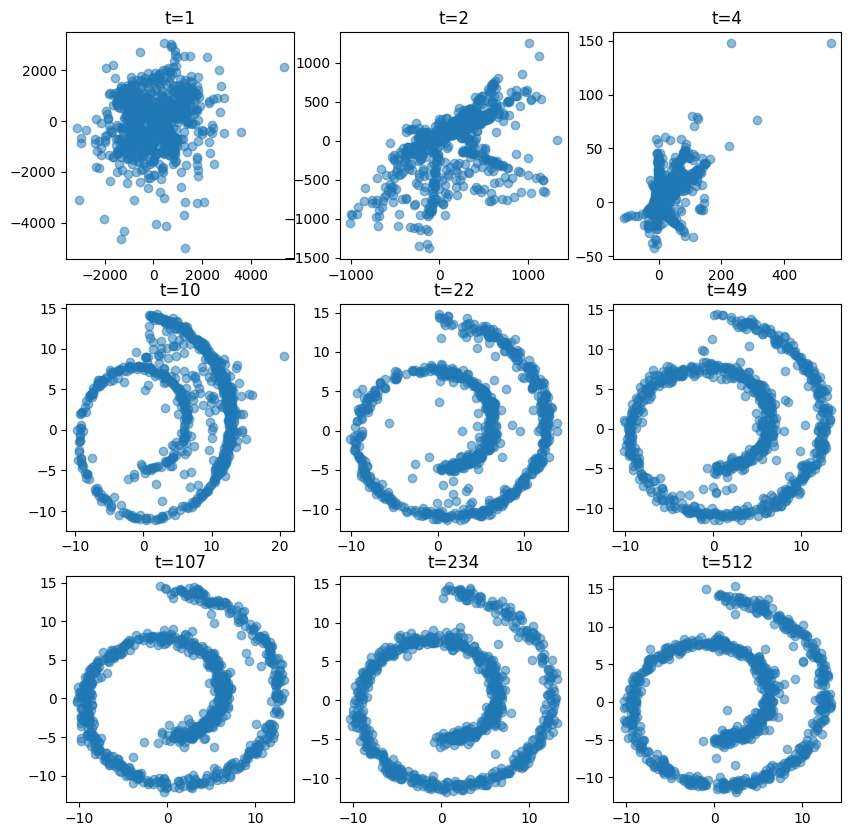

In [25]:
# fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# for i in range(len(return_steps)):
#     ax = axs[i // 3, i % 3]
#     ax.set_title(f"t={return_steps[i]}")
#     ax.scatter(all_samples[i, :, 0], all_samples[i, :, 1], alpha=0.5)

In [ ]:
# # Sample from the model
# num_samples = 20
# num_steps = 100
# return_steps = [0, 1, 5, 10, 50, 99]
# data_dim = 2

# diffusion_model.model.eval()
# ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
# x = torch.randn(num_samples, data_dim, device=ptu.device)

# samples = []
# for i in range(num_steps):
#     t = ptu.tensor([ts[i]], dtype=torch.float32).expand(num_samples, 1)
#     tm1 = ptu.tensor([ts[i + 1]], dtype=torch.float32).expand(num_samples, 1)

#     alpha_t = diffusion_model.get_alpha(t)
#     alpha_tm1 = diffusion_model.get_alpha(tm1)
#     sigma_t = diffusion_model.get_sigma(t)
#     sigma_tm1 = diffusion_model.get_sigma(tm1)

#     eps_hat = diffusion_model.model(x, t)
#     x = diffusion_model.ddpm_update(x, eps_hat, alpha_t, alpha_tm1, sigma_t, sigma_tm1)

#     if i in return_steps:
#         samples.append(x.cpu().detach().numpy())

# samples = np.array(samples)

In [16]:
# for i in range(len(return_steps)):
#     plt.figure()
#     plt.title(f"t={return_steps[i]}")
#     plt.scatter(samples[i, :, 0], samples[i, :, 1], alpha=0.5)

## Results

In [26]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(np.linspace(0, 9, 9), 2).astype(int)
    """
    train_data, test_data, mean, std = norm_mean_std(train_data, test_data)

    model = DiffusionModel(
        train_data, test_data, batch_size=1024, n_epochs=100, n_warmup_steps=100
    )

    # Load
    load_dir = (
        "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q1/2024-03-18_10-27-15"
    )
    model.load(os.path.join(load_dir, "diffusion_model_final.pt"))
    train_losses = np.load(os.path.join(load_dir, "train_losses.npy"))
    test_losses = np.load(os.path.join(load_dir, "test_losses.npy"))

    # Save
    # save_dir = "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q1"
    # train_losses, test_losses = model.train(save_dir=save_dir)

    return_steps = np.logspace(0, np.log10(512), num=9).astype(int)
    all_samples = sample(model, 2000, return_steps, train_data.shape[1:])
    all_samples = unnorm_mean_std(all_samples, mean, std)

    return train_losses, test_losses, all_samples

Final Test Loss: 0.4223


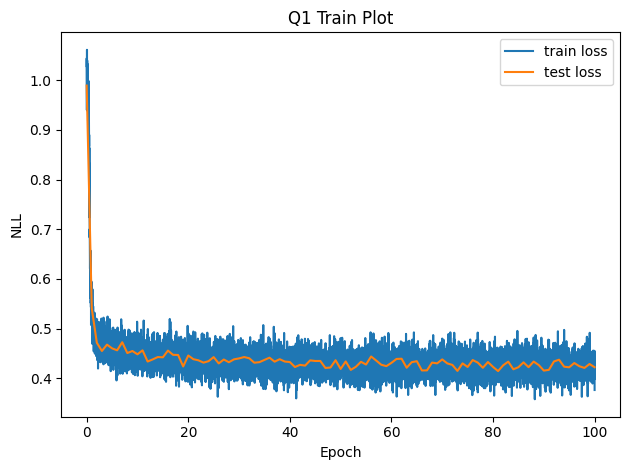

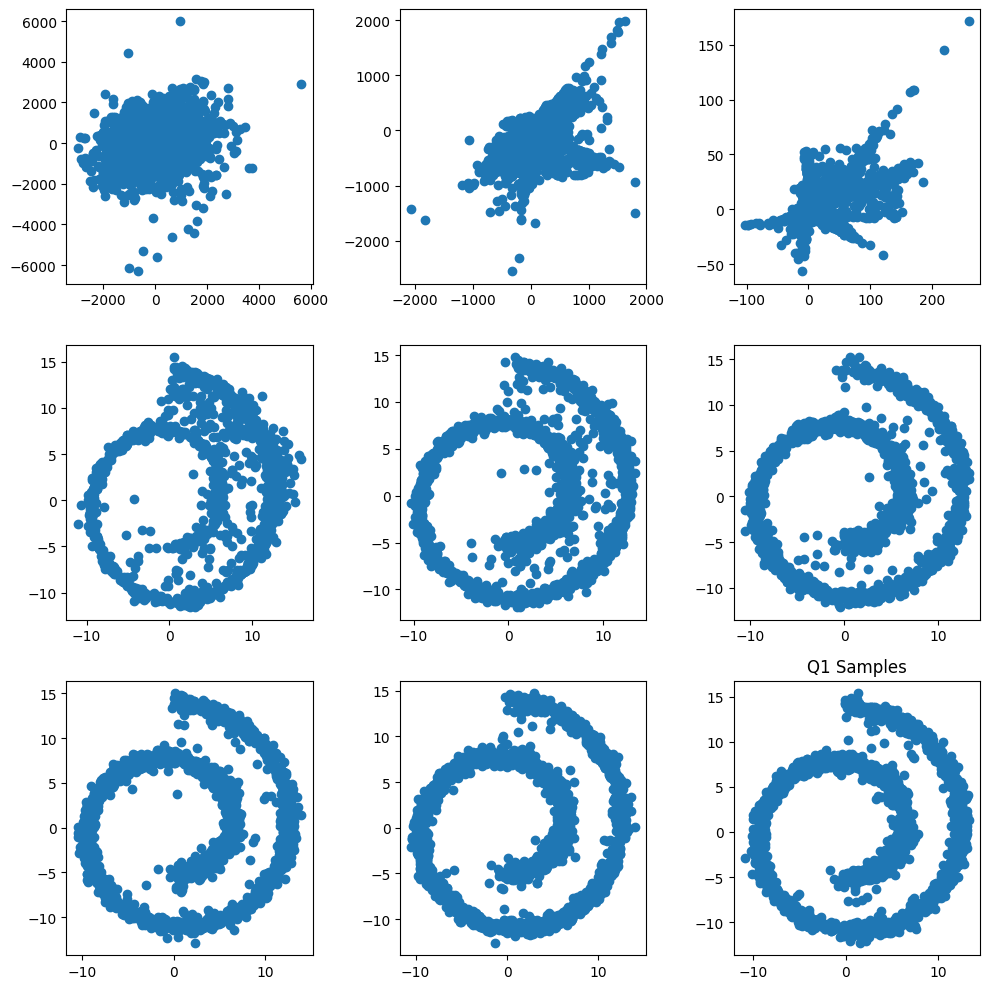

In [27]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

100%|██████████| 170498071/170498071 [00:05<00:00, 33597943.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


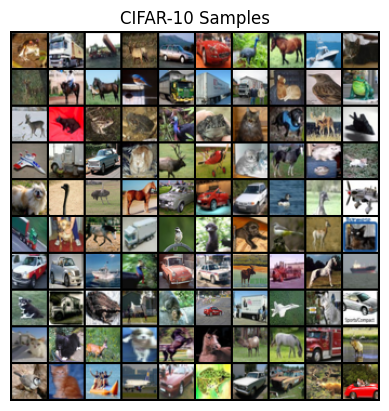

In [231]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t)
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(t)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

## Models

In [30]:
def timestep_embedding(timesteps, dim, max_period=10000):
    half_dim = dim // 2
    freqs = torch.exp(
        -np.log(max_period)
        * torch.arange(0, half_dim, dtype=torch.float32, device=timesteps.device)
        / half_dim
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.temb_proj = nn.Linear(temb_channels, out_channels)
        if in_channels != out_channels:
            self.proj = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.proj = None

    def forward(self, x, temb):
        h = F.silu(self.gn1(self.conv1(x)))
        temb = self.temb_proj(temb)
        h += temb[:, :, None, None]
        h = F.silu(self.gn2(self.conv2(h)))
        if self.proj:
            x = self.proj(x)
        return x + h


class Downsample(nn.Module):
    def __init__(self, in_channels):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels):
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, hidden_dims, blocks_per_dim):
        super(UNet, self).__init__()
        self.hidden_dims = hidden_dims
        self.blocks_per_dim = blocks_per_dim
        self.temb_channels = hidden_dims[0] * 4
        self.emb_proj = nn.Sequential(
            nn.Linear(hidden_dims[0], self.temb_channels),
            nn.SiLU(),
            nn.Linear(self.temb_channels, self.temb_channels),
        )
        self.initial_conv = nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1)
        self.down_blocks = nn.ModuleList()
        self.downsample_layers = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.upsample_layers = nn.ModuleList()

        # Downsample path
        # TODO: make this match pseudocode. Don't downsample at the last (deepest)
        # layer. There should be one downsample block per hidden_dim (except the)
        # last one, and there should be blocks_per_dim number of residual blocks
        # per layer.
        prev_ch = hidden_dims[0]
        # After the double for loop, down_block_chans = [hidden_dims[0]] flatten([[hd] * (blocks_per_dim + 1) for hd in hidden_dims[:-1]]) + [hidden_dims[-1]] * blocks_per_dim
        # self.down_blocks has len(hidden_dims) * blocks_per_dim resblocks.
        # self.downsample_layers has len(hidden_dims) - 1 layers.
        down_block_chans = [prev_ch]
        for i, hidden_dim in enumerate(hidden_dims):
            for _ in range(blocks_per_dim):
                self.down_blocks.append(
                    ResidualBlock(prev_ch, hidden_dim, self.temb_channels)
                )
                prev_ch = hidden_dim
                down_block_chans.append(prev_ch)
            if i != len(hidden_dims) - 1:
                self.downsample_layers.append(Downsample(prev_ch))
                down_block_chans.append(prev_ch)

        # print("After downsample path:")
        # print("down_block_chans:", down_block_chans)

        # Bottleneck. prev_ch = hidden_dims[-1] here.
        self.mid_blocks = nn.ModuleList(
            [
                ResidualBlock(prev_ch, prev_ch, self.temb_channels),
                ResidualBlock(prev_ch, prev_ch, self.temb_channels),
            ]
        )

        # Upsample path
        # TODO: make this match pseudocode. Don't upsample at the first (deepest)
        # layer, and there should be an upsampling block per resblock (excluding
        # the first layer).
        # After the double for loop, self.up_blocks has len(hidden_dims) *
        # blocks_per_dim resblocks.
        # self.upsample_layers has len(hidden_dims) - 1 layers.
        for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
            for j in range(
                blocks_per_dim + 1
            ):  # +1 for the additional block in upsampling
                dch = down_block_chans.pop()
                # NOTE: prev_ch + dch is equivalent to prev_ch * 2.
                self.up_blocks.append(
                    ResidualBlock(prev_ch + dch, hidden_dim, self.temb_channels)
                )
                prev_ch = hidden_dim
                # Only append an upsampling layer if we're not at the deepest
                # layer and we have added all the resblocks for that layer.
                if i != 0 and j == blocks_per_dim:
                    self.upsample_layers.append(Upsample(prev_ch))

        self.final_norm = nn.GroupNorm(num_groups=8, num_channels=prev_ch)
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(prev_ch, in_channels, 3, padding=1)

    def forward(self, x, t):
        temb = timestep_embedding(t, self.hidden_dims[0])
        temb = self.emb_proj(temb)

        h = self.initial_conv(x)
        hs = [h]

        # Downsample
        for i in range(len(self.hidden_dims)):
            for j in range(self.blocks_per_dim):
                h = self.down_blocks[i * self.blocks_per_dim + j](h, temb)
                hs.append(h)
            if i != len(self.hidden_dims) - 1:
                h = self.downsample_layers[i](h)
                hs.append(h)

        # Bottleneck
        for block in self.mid_blocks:
            h = block(h, temb)

        # Upsample
        # print("Upsampling")
        for i, hidden_dim in list(enumerate(self.hidden_dims))[::-1]:
            for j in range(self.blocks_per_dim + 1):
                # print(f"i={i}, j={j}")
                skip_connection = hs.pop()
                # print("h:", h.shape)
                # print("skip_connection:", skip_connection.shape)
                h = torch.cat([h, skip_connection], dim=1)
                # print("h:", h.shape)
                up_block_index = -(i + 1) * (self.blocks_per_dim + 1) + j
                # print("up_block_index:", up_block_index)
                h = self.up_blocks[up_block_index](h, temb)
                # print("h:", h.shape)
                if i != 0 and j == self.blocks_per_dim:
                    # Negate the index because we're going backwards.
                    h = self.upsample_layers[-i](h)
                    # print("i != 0 and j == self.blocks_per_dim")
                    # print("h:", h.shape)
                # print()

        h = self.final_norm(h)
        h = self.final_act(h)
        h = self.final_conv(h)
        return h

In [31]:
# train_data, test_data = load_q2_data()
# train_data = train_data.data / 255.0
# test_data = test_data.data / 255.0

# train_data = train_data.transpose(0, 3, 1, 2)
# test_data = test_data.transpose(0, 3, 1, 2)

# # Normalize to [-1, 1]
# train_data = norm_img(train_data)
# test_data = norm_img(test_data)

# unet = UNet(3, [64, 128, 256, 512], 2)

# dmodel = DiffusionModel(
#     train_data, test_data, model=unet, batch_size=256, n_epochs=1, n_warmup_steps=100
# )
# # train_losses, test_losses = dmodel.train()

In [32]:
# return_steps = np.logspace(0, np.log10(512), num=10).astype(int)
# all_samples = []
# for _ in range(5):
#     samples = sample(dmodel, 2, 512, return_steps, train_data.shape[1:])
#     samples = samples.transpose(0, 1, 3, 4, 2)
#     all_samples.append(samples)

# all_samples = np.concatenate(all_samples, axis=1)
# all_samples = unnorm_img(all_samples)

In [33]:
# from deepul.utils import show_samples
# samples_ = unnorm_img(samples)
# samples_ = samples_.transpose(0, 1, 3, 4, 2)
# samples_ = samples_.reshape(-1, *samples_.shape[2:])
# show_samples(samples_ * 255.0, fname=None, title=f"Q2 CIFAR-10 generated samples")

## Results

In [40]:
# load = True
# train_data, test_data = load_q2_data()
# train_data = train_data.data / 255.0
# test_data = test_data.data / 255.0

# train_data = train_data.transpose(0, 3, 1, 2)
# test_data = test_data.transpose(0, 3, 1, 2)

# # Normalize to [-1, 1]
# train_data = norm_img(train_data)
# test_data = norm_img(test_data)

# unet = UNet(3, [64, 128, 256, 512], 2)

# dmodel = DiffusionModel(
#     train_data,
#     test_data,
#     model=unet,
#     batch_size=256,
#     n_epochs=60,
#     n_warmup_steps=100,
# )

# if load:
#     load_dir = "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q2/2024-03-18_16-32-33"
#     dmodel.load(os.path.join(load_dir, "diffusion_model_final.pt"))
#     train_losses = np.load(os.path.join(load_dir, "train_losses.npy"))
#     test_losses = np.load(os.path.join(load_dir, "test_losses.npy"))
# else:
#     save_dir = "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q2"
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
#     train_losses, test_losses = dmodel.train(save_dir=save_dir)

# return_steps = np.logspace(0, np.log10(512), num=10).astype(int)
# all_samples = []
# clip = (-1, 1)
# all_samples = sample(dmodel, 10, return_steps, train_data.shape[1:], clip=clip)
# # for _ in range(5):
# #     samples = sample(dmodel, 2, return_steps, train_data.shape[1:], clip=clip)
# #     samples = samples.transpose(0, 1, 3, 4, 2)
# #     all_samples.append(samples)

# # all_samples = np.concatenate(all_samples, axis=0)
# all_samples = unnorm_img(all_samples)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
def q2(train_data, test_data, load=True):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(np.linspace(0, 9, 10), 2).astype(int)
    """
    train_data = train_data.transpose(0, 3, 1, 2)
    test_data = test_data.transpose(0, 3, 1, 2)

    # Normalize to [-1, 1]
    train_data = norm_img(train_data)
    test_data = norm_img(test_data)

    unet = UNet(3, [64, 128, 256, 512], 2)

    dmodel = DiffusionModel(
        train_data,
        test_data,
        model=unet,
        batch_size=256,
        n_epochs=60,
        n_warmup_steps=100,
    )

    if load:
        load_dir = "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q2/2024-03-18_16-32-33"
        dmodel.load(os.path.join(load_dir, "diffusion_model_final.pt"))
        train_losses = np.load(os.path.join(load_dir, "train_losses.npy"))
        test_losses = np.load(os.path.join(load_dir, "test_losses.npy"))
    else:
        save_dir = "/nas/ucb/ebronstein/deepul/deepul/homeworks/hw4/models/q2"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        train_losses, test_losses = dmodel.train(save_dir=save_dir)

    return_steps = np.logspace(0, np.log10(512), num=10).astype(int)
    clip = (-1, 1)
    samples = sample(dmodel, 10, return_steps, train_data.shape[1:], clip=clip)
    samples = samples.transpose(0, 1, 3, 4, 2)
    samples = unnorm_img(samples)

    return train_losses, test_losses, samples

Files already downloaded and verified
Files already downloaded and verified
Final Test Loss: 0.1858


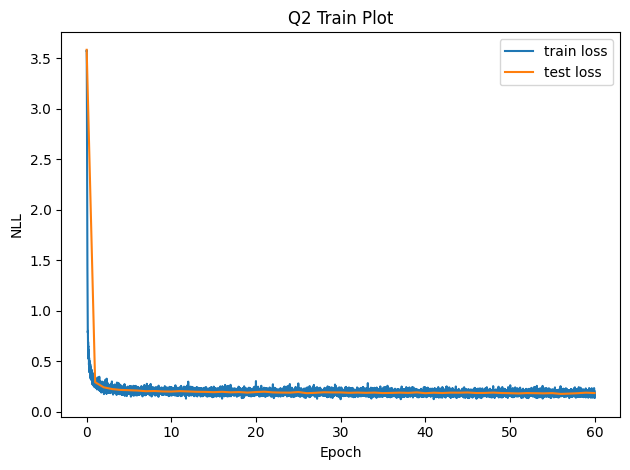

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


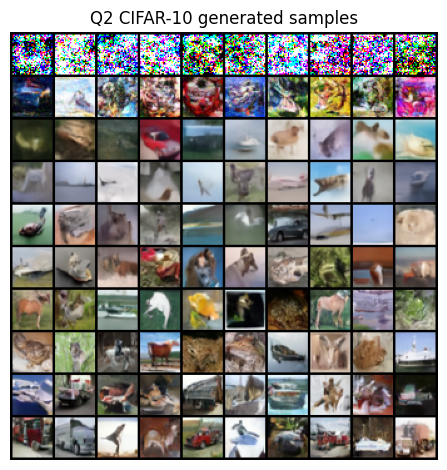

In [43]:
q2_save_results(q2)

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


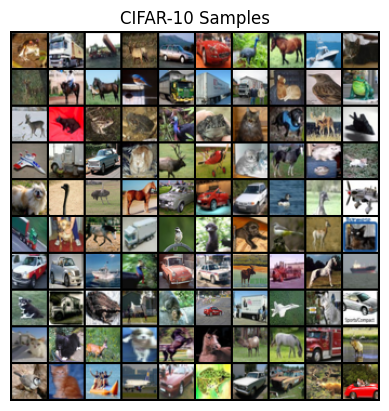

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [38]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [22]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """
    images_ = norm_img(images)
    images_ = ptu.tensor(images_).float().permute(0, 3, 1, 2)
    autoencoded_images = vae.encode(images_)
    scale_factor = autoencoded_images.flatten().std().item()

    real_img = images[:50]
    recon_img = vae.decode(autoencoded_images[:50]).detach().cpu().numpy()
    recon_img = recon_img.transpose(0, 2, 3, 1)
    recon_img = unnorm_img(recon_img)
    real_and_recon_imgs = np.stack([real_img, recon_img], axis=1)

    return real_and_recon_imgs, scale_factor

Files already downloaded and verified
Files already downloaded and verified


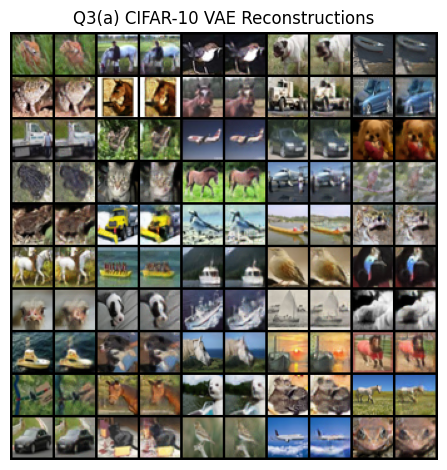

Scale factor: 1.2716


In [23]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

## Utils

In [20]:
def dropout_classes(y, null_class, dropout_prob=0.1):
    """Randomly dropout classes with a given probability."""
    dropout_mask = torch.rand(y.shape) < dropout_prob
    y[dropout_mask] = null_class
    return y


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


def patchify_flatten(images, patch_size):
    """
    Convert encoded images to flattened patches.

    Args:
        images: Tensor of shape (B, D, H, W)
        patch_size: Size of each patch (P)

    Returns:
        Flattened patches of shape (B, L, patch_size * patch_size * D) where L
        is the number of patches.
    """
    B, D, H, W = images.shape
    # [B, D, H // patch_size, patch_size, W // patch_size, patch_size]
    images = images.reshape(
        B, D, H // patch_size, patch_size, W // patch_size, patch_size
    )
    # [B, H // patch_size, W // patch_size, patch_size, patch_size, D]
    images = images.permute(0, 2, 4, 3, 5, 1)
    # [B, H // patch_size * W // patch_size, patch_size, patch_size, D]
    images = images.flatten(1, 2)
    # [B, H // patch_size * W // patch_size, patch_size * patch_size * D]
    return images.flatten(2, 4)


def unpatchify(patches, patch_size, H, W, D):
    """
    Convert flattened patches back to encoded images.

    Args:
        patches: Tensor of shape (B, L, patch_size * patch_size * D)
        patch_size: Size of each patch (P)
        H: Original height of the image
        W: Original width of the image
        D: Number of latent dimensions in the encoded image

    Returns:
        Images of shape (B, D, H, W).
    """
    B = patches.shape[0]
    patches = patches.reshape(
        B, H // patch_size, W // patch_size, patch_size, patch_size, D
    )
    patches = patches.permute(0, 5, 1, 3, 2, 4)
    images = patches.reshape(B, D, H, W)
    return images

In [31]:
# B = 2
# D = 4
# H = 8
# W = 8
# img = torch.rand(B, D, H, W)

# patch_size = 2
# flat_patches = patchify_flatten(img, patch_size)
# unpatched = unpatchify(flat_patches, patch_size, H, W, D)
# assert (img - unpatched).abs().max() < 1e-6

## Models

In [22]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        """
        Args:
            images: The image data of shape (N, H, W, D)
            labels: The label data of shape (N,)
        """
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label


class MLP(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, 4 * hidden_size)
        self.fc2 = nn.Linear(4 * hidden_size, hidden_size)
        self.act = nn.GELU()

    def forward(self, x):
        # TODO: maybe apply LayerNorm first.
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, seq_len):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # Linear layers that project the input to Q, K, and V for all heads.
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

        # Create a mask for autoregressive property.
        # 0 means valid position, 1 means masked position.
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        mask = mask.masked_fill(mask == 1, -1e9)
        self.register_buffer("mask", mask)

        self.cache = None

    def split_heads(self, x, batch_size):
        """Split x into self.num_heads pieces.

        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
            batch_size: Batch size

        Returns:
            Tensor of shape (batch_size, num_heads, seq_len, depth)
        """
        # Shape: [batch_size, seq_len, num_heads, depth]
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, use_cache=False):
        """Apply forward pass.

        Args:
            q: Query tensor of shape (batch_size, seq_len, d_model)
            k: Key tensor of shape (batch_size, seq_len, d_model)
            v: Value tensor of shape (batch_size, seq_len, d_model)
            use_cache: Whether to use cache for fast decoding. If True, q, k, and v
                have shape (batch_size, 1, d_model).

        Returns:
            Hidden state tensor of shape (batch_size, seq_len, d_model).
        """
        batch_size = q.size(0)

        # [batch_size, num_heads, 1, depth]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        if use_cache:
            if self.cache is not None:
                # Concatenate with the cached keys and values
                # [batch_size, num_heads, seq_len, depth]
                k = torch.cat([self.cache["k"], k], dim=2)
                v = torch.cat([self.cache["v"], v], dim=2)
            # Update cache
            self.cache = {"k": k, "v": v}

        # [batch_size, num_heads, seq_len, seq_len]
        scaled_attention_logits = torch.matmul(q, k.transpose(-2, -1)) / self.depth**0.5

        # Apply mask to the scaled attention logits if not using cache.
        if not use_cache:
            seq_len = q.size(2)
            scaled_attention_logits += self.mask[:seq_len, :seq_len]

        # Shape: [batch_size, num_heads, seq_len, seq_len]
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)

        # Shape: [batch_size, num_heads, seq_len, depth]
        output = torch.matmul(attention_weights, v)
        # Concatenate the output of all heads
        output = (
            output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        )

        return self.dense(output)

    def clear_cache(self):
        self.cache = None

    def is_cache_empty(self):
        return self.cache is None


class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.layer_norm = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.linear1 = nn.Linear(hidden_size, 2 * hidden_size)
        self.linear2 = nn.Linear(hidden_size, patch_size * patch_size * out_channels)

    def forward(self, x, c):
        c = F.silu(c)
        c = self.linear1(c)
        shift, scale = c.chunk(2, dim=1)
        x = self.layer_norm(x)
        x = modulate(x, shift, scale)
        x = self.linear2(x)
        return x


class DiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, seq_len):
        super().__init__()
        self.linear = nn.Linear(hidden_size, 6 * hidden_size)
        self.layer_norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.layer_norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.mha = MultiHeadAttention(hidden_size, num_heads, seq_len)
        self.mlp = MLP(hidden_size)

    def forward(self, x, c):
        c = F.silu(c)
        c = self.linear(c)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(
            6, dim=1
        )

        h = self.layer_norm1(x)
        h = modulate(h, shift_msa, scale_msa)
        x = x + gate_msa.unsqueeze(1) * self.mha(h, h, h)

        h = self.layer_norm2(x)
        h = modulate(h, shift_mlp, scale_mlp)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(h)

        return x


class DiT(nn.Module):
    def __init__(
        self,
        input_shape,
        patch_size=2,
        hidden_size=512,
        num_heads=8,
        num_layers=12,
        num_classes=10,
        dropout_prob=0.1,
    ):
        super().__init__()
        self.patch_size = patch_size
        self.hidden_size = hidden_size
        _, D, H, W = input_shape
        self.H, self.W, self.D = H, W, D
        pos_embed = get_2d_sincos_pos_embed(patch_size**2 * D, H // patch_size)
        pos_embed = ptu.tensor(pos_embed, dtype=torch.float32)
        self.register_buffer("pos_embed", pos_embed)

        self.num_classes = num_classes
        self.embedding = nn.Embedding(num_classes + 1, hidden_size)
        seq_len = patch_size**2 * D
        self.blocks = nn.ModuleList(
            [DiTBlock(hidden_size, num_heads, seq_len) for _ in range(num_layers)]
        )
        self.final_layer = FinalLayer(hidden_size, patch_size, D)
        self.dropout_prob = dropout_prob

    def forward(self, x, y, t, training=True):
        # B, D, H, W = x.shape

        x = patchify_flatten(x, self.patch_size)
        x += self.pos_embed.unsqueeze(0)

        t_emb = timestep_embedding(t, self.hidden_size)
        if training:
            y = dropout_classes(y, self.num_classes, dropout_prob=self.dropout_prob)
        y_emb = self.embedding(y)
        c = t_emb + y_emb

        for block in self.blocks:
            x = block(x, c)

        x = self.final_layer(x, c)
        x = unpatchify(x, self.patch_size, self.H, self.W, self.D)
        return x

In [23]:
train_data, test_data = load_q3_data()
train_images = train_data.data / 255.0
train_labels = np.array(train_data.targets, dtype=np.int32)
test_images = test_data.data / 255.0
test_labels = np.array(test_data.targets, dtype=np.int32)
vae = load_pretrain_vae()

Files already downloaded and verified
Files already downloaded and verified


In [57]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        """
        Args:
            images: The image data of shape (N, H, W, D)
            labels: The label data of shape (N,)
        """
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

In [24]:
train_data_ = norm_img(train_images)
test_data_ = norm_img(test_images)
train_data_ = ptu.tensor(train_data_).float().permute(0, 3, 1, 2)
test_data_ = ptu.tensor(test_data_).float().permute(0, 3, 1, 2)
enc_train_data = vae.encode(train_data_)
enc_test_data = vae.encode(test_data_)

scale_factor = 1.2716
# [50000, 4, 8, 8]
enc_train_data = enc_train_data / scale_factor
enc_test_data = enc_test_data / scale_factor

batch_size = 256
train_dataset = CustomImageDataset(enc_train_data, train_labels)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_dataset = CustomImageDataset(enc_test_data, test_labels)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 586.00 MiB. GPU 0 has a total capacty of 47.54 GiB of which 20.12 MiB is free. Process 507372 has 5.86 GiB memory in use. Process 1003535 has 358.00 MiB memory in use. Process 1492135 has 358.00 MiB memory in use. Process 398869 has 772.00 MiB memory in use. Process 1871116 has 2.83 GiB memory in use. Process 3652520 has 35.92 GiB memory in use. Including non-PyTorch memory, this process has 1.42 GiB memory in use. Of the allocated memory 1.16 GiB is allocated by PyTorch, and 3.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [97]:
patch_size = 2
hidden_size = 512
num_heads = 8
num_layers = 12
num_classes = 10
dit = DiT(
    enc_train_data.shape,
    patch_size=patch_size,
    hidden_size=hidden_size,
    num_heads=num_heads,
    num_classes=num_classes,
)

dmodel = DiffusionModel(
    train_loader,
    test_loader,
    model=dit,
    n_epochs=60,
    n_warmup_steps=100,
    has_labels=True,
)

In [98]:
train_losses, test_losses = dmodel.train()

RuntimeError: Given normalized_shape=[512], expected input with shape [*, 512], but got input of size[256, 16, 16]

In [70]:
dit

DiT(
  (embedding): Embedding(11, 512)
  (blocks): ModuleList(
    (0-11): 12 x DiTBlock(
      (linear): Linear(in_features=512, out_features=3072, bias=True)
      (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
      (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
      (mha): MultiHeadAttention(
        (wq): Linear(in_features=512, out_features=512, bias=True)
        (wk): Linear(in_features=512, out_features=512, bias=True)
        (wv): Linear(in_features=512, out_features=512, bias=True)
        (dense): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): MLP(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (act): GELU(approximate='none')
      )
    )
  )
  (final_layer): FinalLayer(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
    (linear1): Linear(in_features=512, out_features=1024, bi

In [ ]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """

    return train_losses, test_losses, samples

In [ ]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [ ]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """

    return samples

In [ ]:
q3c_save_results(q3_c)